# Оптимизация маркетинговых затрат


## Этап 1. Получение данных

### Импорт библиотек, загрузка данных, общая информация о данных таблицы


### Описание данных:

1.Таблица visits (лог сервера с информацией о посещениях сайта):

- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии

2.Таблица orders (информация о заказах):

- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

3.Таблица costs (информация о затратах на маркетинг):

- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

In [6]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt


costs = pd.read_csv('/datasets/costs.csv', sep =',')
orders = pd.read_csv('/datasets/orders_log.csv', sep =',',  parse_dates=['Buy Ts'], dayfirst=False)
visits = pd.read_csv('/datasets/visits_log.csv', sep =',',  parse_dates=['Start Ts','End Ts'], dayfirst=True)

display('costs', costs.head(3))
display(costs.info())

display('orders', orders.head(3))
display(orders.info())

display('visits', visits.head(3))
display(visits.info())




'costs'

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

'orders'

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


None

'visits'

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


None

Файлы загружены и проанализированы. Для корректного анализа необходимо изменить формат  дат на datetime. Привести названия столбцов к нижнему регистру. 

In [7]:
costs['dt'] = pd.to_datetime(costs['dt'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])

costs.columns = costs.columns.str.lower()
costs['source_id'] = costs['source_id'].astype('object')
orders = orders.rename(columns={'Buy Ts':'Buy_Ts'})
orders.columns = orders.columns.str.lower()
visits = visits.rename(columns={'Source Id':'Source_Id', 'Start Ts':'Start_Ts', 'End Ts':'End_Ts'})
visits.columns = visits.columns.str.lower()
visits['source_id']= visits['source_id'].astype('object')


display('costs', costs.head(3))
display(costs.info())

display('orders', orders.head(3))
display(orders.info())

display('visits', visits.head(3))
display(visits.info())

visits_copy = visits.copy()
orders_copy = orders.copy()

'costs'

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null object
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 59.7+ KB


None

'orders'

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


None

'visits'

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null object
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), object(2), uint64(1)
memory usage: 13.7+ MB


None

In [8]:
print(orders['revenue'].sum().astype('int'))
print(orders['uid'].nunique())
print(visits['uid'].nunique())
print(visits['uid'].count())
print(orders['buy_ts'].count())

252057
36523
228169
359400
50415


## Продукт
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

In [9]:
display(visits.groupby('source_id')['uid'].count())

source_id
1      34121
2      47626
3      85610
4     101794
5      66905
6          6
7         36
9      13277
10     10025
Name: uid, dtype: int64

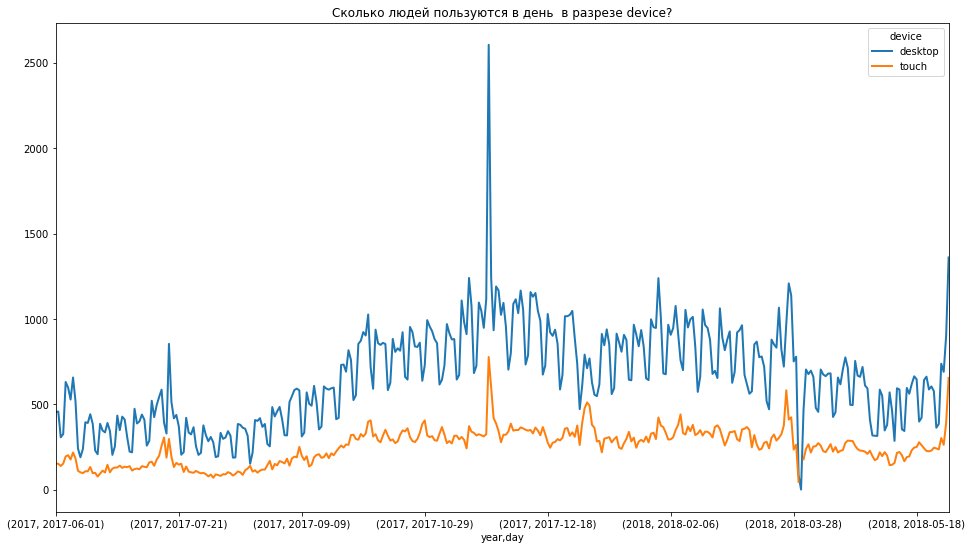

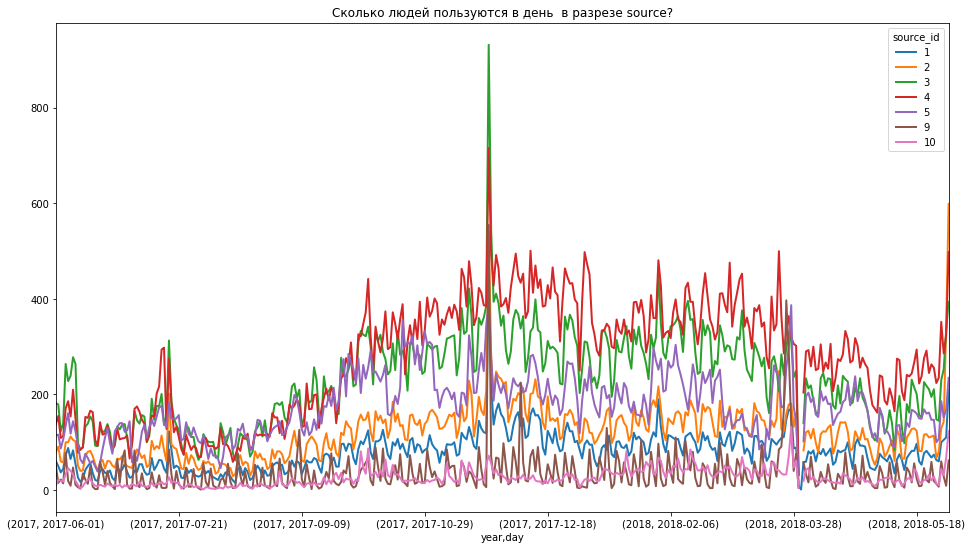

In [10]:
# Сделаем срез, исключим источники 6 и 7, по ним очень мало визитов и это не повлияет на расчеты 
# Retention, mau/wau/dau в дальнейшем.

visits = visits.query('source_id != 6')
visits = visits.query('source_id != 7')
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits['day'] = visits['start_ts'].dt.date
visits['year'] = visits['start_ts'].dt.year

# • Сколько людей пользуются в день?
dau_visits = visits.groupby(['day']).agg({'uid': 'nunique'})
dau_visits_device = visits.pivot_table(index = ['year','day'], values = 'uid', aggfunc ='nunique', columns = 'device' )
dau_visits_source = visits.pivot_table(index = ['year','day'], values = 'uid', aggfunc ='nunique', columns = 'source_id' )

dau_visits_device.plot(figsize=(16, 9), title='Сколько людей пользуются в день  в разрезе device?', linewidth = 2)
plt.show()
dau_visits_source.plot(figsize=(16, 9), title='Сколько людей пользуются в день  в разрезе source?', linewidth = 2)
plt.show()



#### Вывод:
На графике видны явные всплески пользовательской активности:особенно предновогодние дни,8 марта. Активность возрастает начиная с сентября, пик перед новым годоми потом идет на плавный спад.
С desctop заходят чаще, чем с touch. Основной поток из источников 3 и 4.

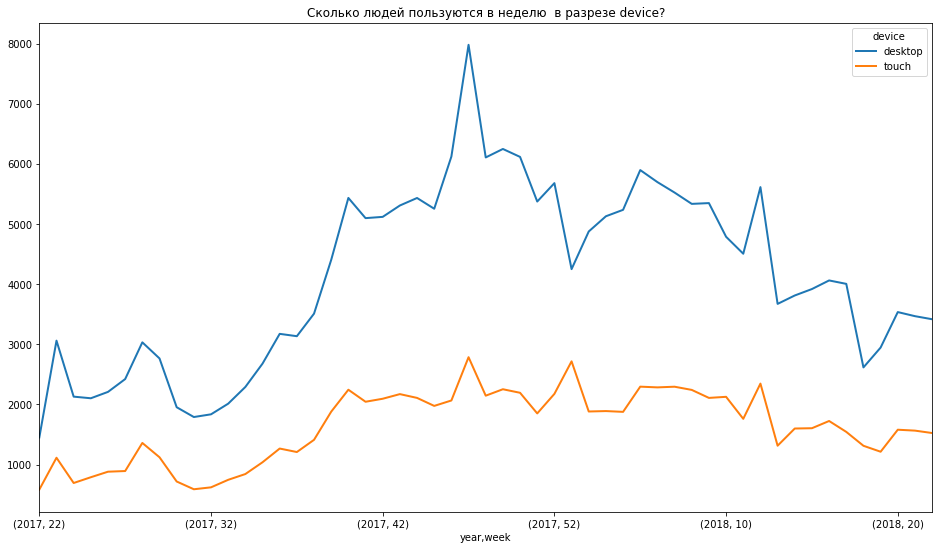

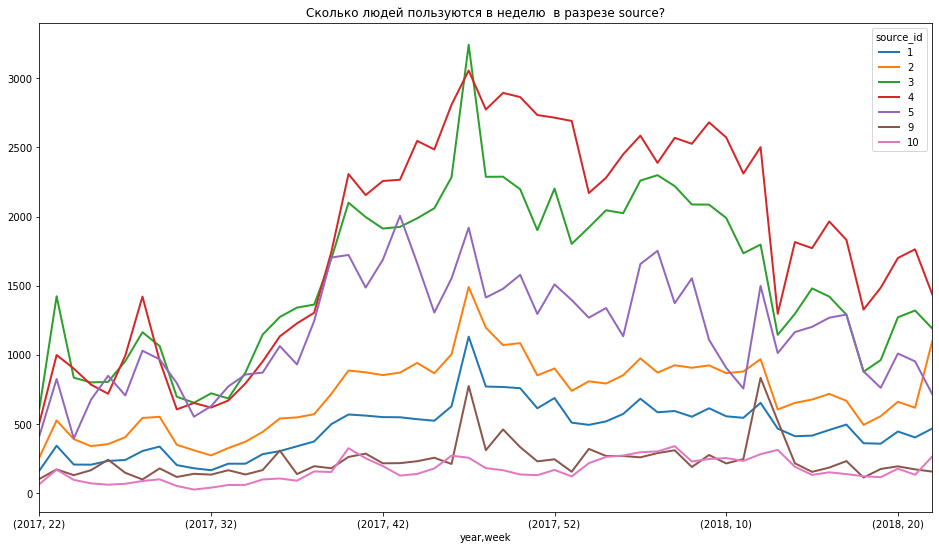

In [11]:
wau_visits = visits.groupby(['week']).agg({'uid': 'nunique'})
wau_visits_device = visits.pivot_table(index = ['year', 'week'], values = 'uid', aggfunc ='nunique', columns = 'device' )
wau_visits_source = visits.pivot_table(index = ['year', 'week'], values = 'uid', aggfunc ='nunique', columns = 'source_id' )


wau_visits_device.plot(figsize=(16, 9), title='Сколько людей пользуются в неделю  в разрезе device?', linewidth = 2)
plt.show()

wau_visits_source.plot(figsize=(16, 9), title='Сколько людей пользуются в неделю  в разрезе source?', linewidth = 2)
plt.show()



#### Вывод:
По неделям аналогичный вывод:
На графике видны явные всплески пользовательской активности:особенно предновогодние дни,8 марта. Активность возрастает начиная с сентября, пик перед новым годоми потом идет на плавный спад.
С desctop заходят чаще, чем с touch. Основной поток из источников 3 и 4.

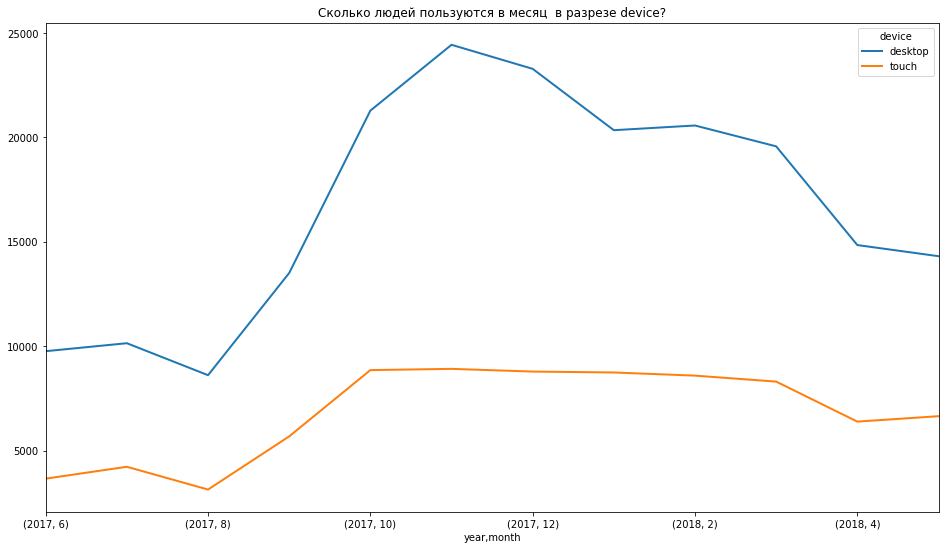

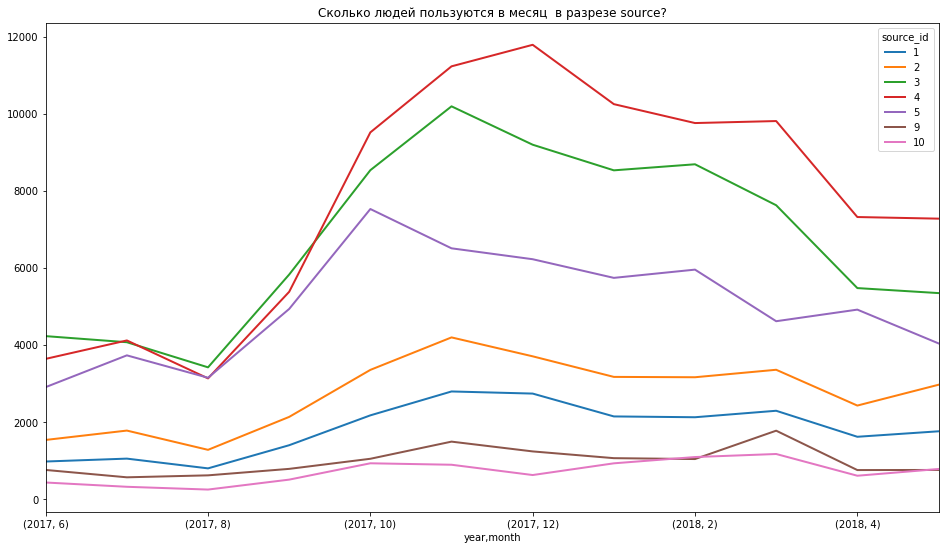

In [12]:
mau_visits = visits.groupby(['month']).agg({'uid': 'nunique'})
mau_visits_device = visits.pivot_table(index =['year', 'month'], values = 'uid', aggfunc ='nunique', columns = 'device' )
mau_visits_source = visits.pivot_table(index =['year', 'month'], values = 'uid', aggfunc ='nunique', columns = 'source_id' )

mau_visits_device.plot(figsize=(16, 9), title='Сколько людей пользуются в месяц  в разрезе device?', linewidth = 2)
plt.show()
mau_visits_source.plot(figsize=(16, 9), title='Сколько людей пользуются в месяц  в разрезе source?', linewidth = 2)
plt.show()



#### Вывод:
По месяцам аналогичный вывод:
На графике видны явные всплески пользовательской активности:особенно предновогодние дни,8 марта. Активность возрастает начиная с сентября, пик перед новым годоми потом идет на плавный спад.
С desctop заходят чаще, чем с touch. Основной поток из источников 3 и 4.

In [13]:
print('DAUvisits', int(dau_visits.mean()))
print('WAUvisits', int(wau_visits.mean()))
print('MAUvisits', int(mau_visits.mean()))




DAUvisits 907
WAUvisits 5824
MAUvisits 23225


'count_sessions'

,uid
count,364.000000
mean,987.247253
std,418.944560
min,1.000000
25%,635.500000
50%,1003.000000
75%,1280.000000
max,4042.000000


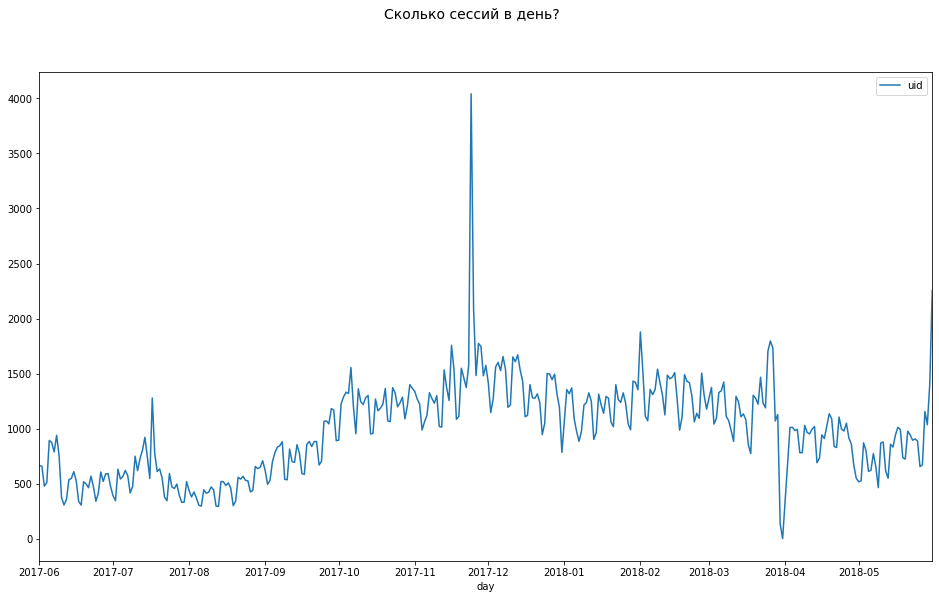

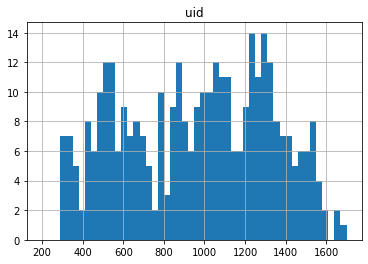

In [14]:
# • Сколько сессий в день?

count_sessions =  visits.groupby('day').agg({'uid': 'count'})
display('count_sessions', count_sessions.describe())
count_sessions.plot(kind = 'line', figsize = (16,9))
plt.suptitle("Сколько сессий в день?", fontsize=14)
count_sessions.hist(bins = 50, range = (200, 1700))
plt.show()



#### Выводы:
Сколько сессий в день?

Среднее количество сессий в день 987, максимальное число сессий в день 4042.

In [15]:
# Полезно изучить то, сколько сессий приходится на одного пользователя, например, за месяц.
# Это хороший показатель регулярности использования приложения.
# Найти эту метрику просто — разделим число сессий на количество пользователей за период:

sessions_per_user = visits.groupby('month').agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
display('sessions_per_user', sessions_per_user.head(3))



'sessions_per_user'

,n_sessions,n_users,sessions_per_user
month,,,
1,36934,28712,1.286361
2,37177,28747,1.293248
3,35678,27472,1.298704


#### Вывод:
Полезно изучить то, сколько сессий приходится на одного пользователя, например, за месяц.
Это хороший показатель регулярности использования приложения.
Найти эту метрику просто — разделим число сессий на количество пользователей за период:на каждого пользователя приходится в среднем 1,29 сессии.

'Сколько длится одна сессия?'

count                    359356
mean     0 days 00:10:43.033793
std      0 days 00:16:37.077103
min             0 days 00:00:00
25%             0 days 00:02:00
50%             0 days 00:05:00
75%             0 days 00:14:00
max             0 days 11:51:00
Name: duration, dtype: object

'Mode'

0   00:01:00
dtype: timedelta64[ns]

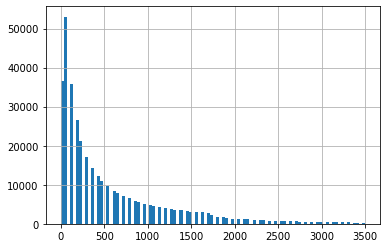

In [16]:
# • Сколько длится одна сессия?
visits['duration'] = visits['end_ts'] - visits['start_ts'] 
visits = visits.query('duration >= "0 days 00:00:00"')
display('Сколько длится одна сессия?', visits['duration'].describe(), 'Mode', visits['duration'].mode())
visits['duration'].dt.total_seconds().hist(bins = 100, range =(0, 3500))


#### Выводы:

- Сколько длится одна сессия?

В среднем сессия длится 10,43 мин, но и может достигать максисму в 11 часов 51мин. Но это больше исключение. От 2 до 14 мин это нормальное время для сессии. Мода равна 1 мин.

In [17]:
# • Как часто люди возвращаются? Когортный анализ и Retention Rate
# Выделим дату первого визита:
first_visits_date = visits.groupby(['uid'])['start_ts'].min()
first_visits_date.name = 'first_visits_date'
visits = visits.merge(first_visits_date, on='uid')
visits['first_visits_date'] = pd.to_datetime(visits['first_visits_date'])
visits['first_visits_month'] = visits['first_visits_date'].astype('datetime64[M]')
visits['visits_month'] = visits['start_ts'].astype('datetime64[M]')


with pd.option_context('display.max_rows', None, 'display.max_columns', None):
     display(visits.head(3))



,device,end_ts,source_id,start_ts,uid,week,month,day,year,duration,first_visits_date,first_visits_month,visits_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,51,12,2017-12-20,2017,00:18:00,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,8,2,2018-02-19,2018,00:28:00,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,26,7,2017-07-01,2017,00:00:00,2017-07-01 01:54:00,2017-07-01,2017-07-01


In [18]:
# Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты.
# В качестве делителя обратимся к константе np.timedelta64(1,'M') (где 'M' от англ. month, «месяц»).
# За начало когорты берем дату первого визита.

visits['cohort_lifetime'] = visits['visits_month'] - visits['first_visits_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

# Сгруппируем данные по когорте и lifetime. 
# Посчитаем для каждой когорты количество активных пользователей на определённый месяцжизни»:

cohorts_lifetime = visits.groupby(['first_visits_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts_lifetime_device = visits.groupby(['device','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts_lifetime_source = visits.groupby(['source_id','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
display('cohorts_lifetime', cohorts_lifetime.head(3))



'cohorts_lifetime'

,first_visits_month,cohort_lifetime,uid
0,2017-06-01,0,13257
1,2017-06-01,1,1043
2,2017-06-01,2,712


In [19]:
# Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте,
# и на него разделить число пользователей в каждую следующую неделю.
# Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц:
initial_users_count = cohorts_lifetime[cohorts_lifetime['cohort_lifetime'] == 0][['first_visits_month','uid']]
initial_users_count_device = cohorts_lifetime_device[cohorts_lifetime_device['cohort_lifetime'] == 0][['device','uid']]
initial_users_count_source = cohorts_lifetime_source[cohorts_lifetime_source['cohort_lifetime'] == 0][['source_id','uid']]

initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
initial_users_count_device = initial_users_count_device.rename(columns={'uid':'cohort_device_users'})
initial_users_count_source = initial_users_count_source.rename(columns={'uid':'cohort_users'})


In [20]:
# Объединим данные по когортам с исходным количеством пользователей в когорте:

cohorts_lifetime = cohorts_lifetime.merge(initial_users_count, on='first_visits_month')
cohorts_lifetime_device = cohorts_lifetime_device.merge(initial_users_count_device, on='device')
cohorts_lifetime_source = cohorts_lifetime_source.merge(initial_users_count_source, on='source_id')



In [21]:
# Рассчитаем Retention Rate. 
# Разделим количество активных пользователей в каждую из месяцев на исходное число пользователей в когорте:


cohorts_lifetime['retention'] = cohorts_lifetime['uid']/cohorts_lifetime['cohort_users']
cohorts_lifetime_device['retention'] = cohorts_lifetime_device['uid']/cohorts_lifetime_device['cohort_device_users']
cohorts_lifetime_source['retention'] = cohorts_lifetime_source['uid']/cohorts_lifetime_source['cohort_users']



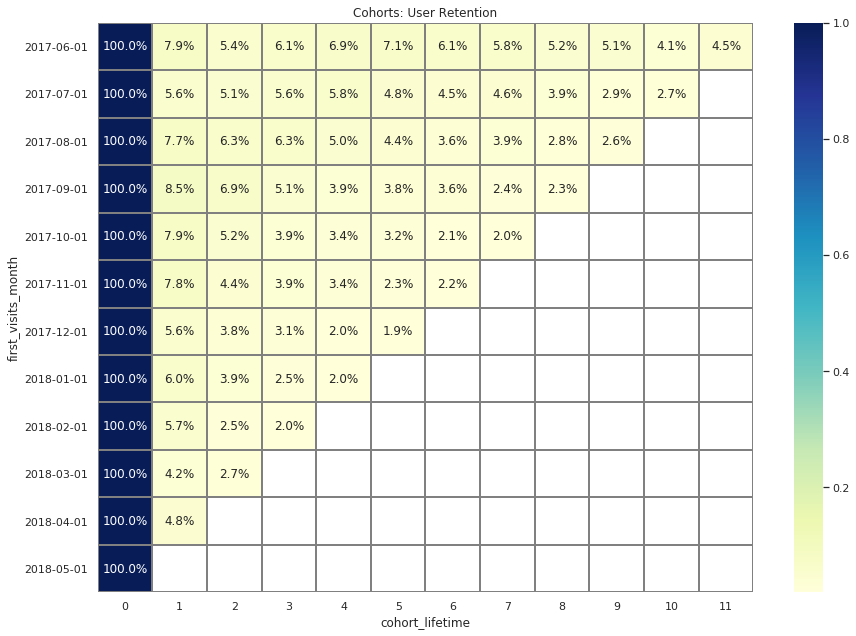

In [22]:
#  Построим сводную таблицу и создадим тепловую карту:

cohorts_lifetime['first_visits_month'] = cohorts_lifetime['first_visits_month'].dt.strftime('%Y-%m-%d')

retention_pivot = cohorts_lifetime.pivot_table(index='first_visits_month', 
                                               columns='cohort_lifetime', 
                                               values='retention', 
                                               aggfunc='sum')

# display('user retention', retention_pivot)      
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap="YlGnBu")
plt.tight_layout()
plt.show()




#### Вывод:
- Как часто люди возвращаются?
Для этого сделаем когортный анализ и посчитаем Retention Rate. Пользователи, которые присоединились в четвертую, пятую и шестую когорту. Они имеею более высокий процент удержания в первый месяц 7,8-8%, чем пользователи, других когорт, но затем пользователи быстрее покидают эти когорты, чем например пользователи 1, 2 и 3 когорты. Как раз, скоро Новый год и пользователи дольше остаются.  В первый месяц возвращается не более 7,5-8%, во второй уже 5-6%.

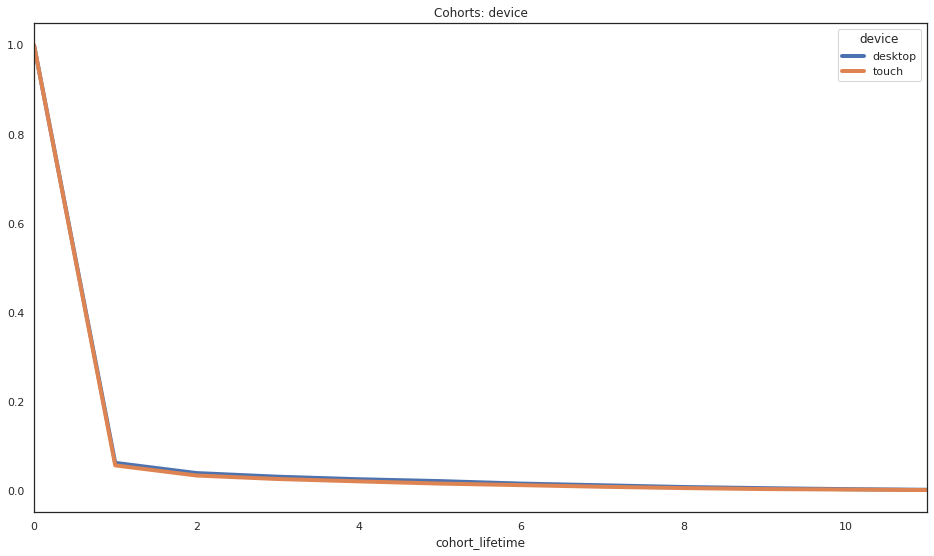

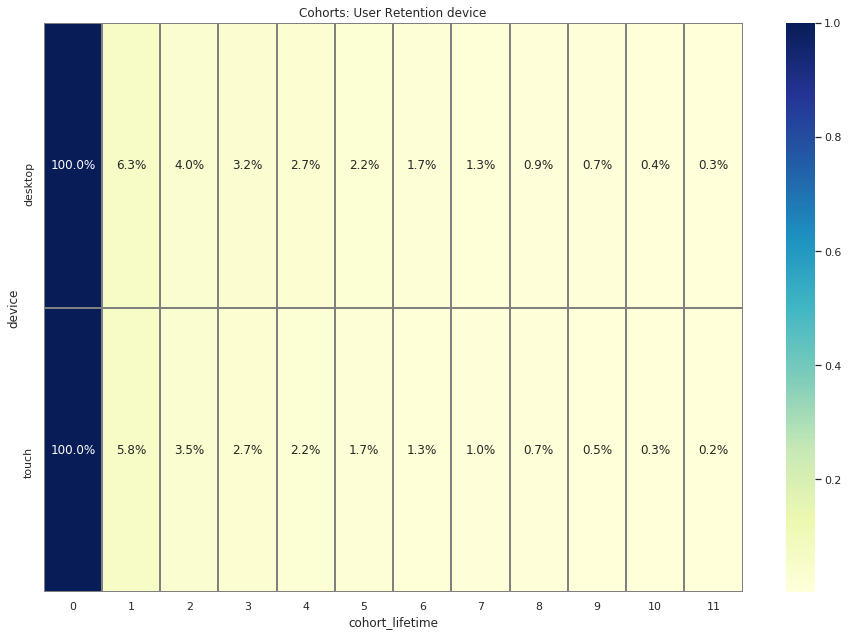

In [23]:
retention_pivot_device = cohorts_lifetime_device.pivot_table(index='device', 
                                                             columns='cohort_lifetime', 
                                                             values='retention', 
                                                             aggfunc='sum')

device = cohorts_lifetime_device.pivot_table(index='cohort_lifetime', 
                                             columns='device', 
                                             values='retention', 
                                             aggfunc='sum')
device.plot(figsize=(16, 9), title='device', linewidth = 4)
plt.title('Cohorts: device')
plt.show()


# display('User Retention device', retention_pivot_device)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention device')
sns.heatmap(retention_pivot_device, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap="YlGnBu")
plt.tight_layout()
plt.show()


#### ВЫВОДЫ: 
Retention по device отличается не сильно, всего на 0,5%.

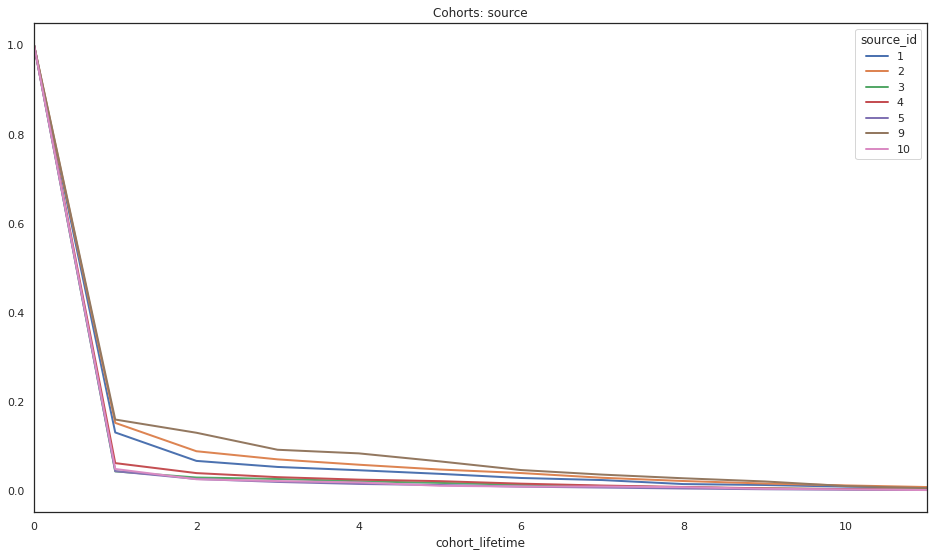

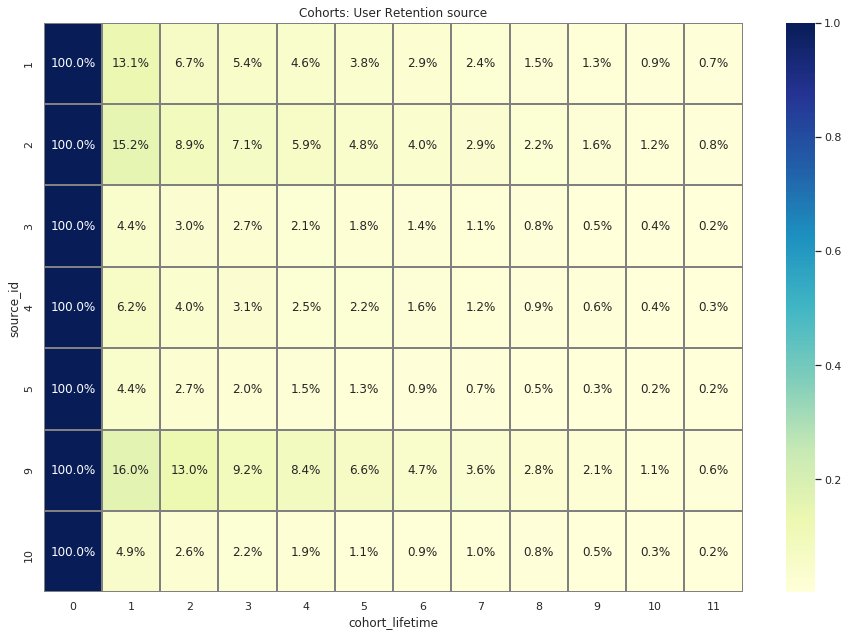

In [24]:
retention_pivot_source = cohorts_lifetime_source.pivot_table(index='source_id', 
                                                             columns='cohort_lifetime', 
                                                             values='retention', 
                                                             aggfunc='sum')


source = cohorts_lifetime_source.pivot_table(index='cohort_lifetime', 
                                             columns='source_id', 
                                             values='retention', 
                                             aggfunc='sum')
source.plot(figsize=(16, 9), title='source', linewidth = 2)
plt.title('Cohorts: source')
plt.show()


# display('User Retention source', retention_pivot_source)
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention source')
sns.heatmap(retention_pivot_source, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap="YlGnBu")
plt.tight_layout()
plt.show()


#### Вывод:
- Как часто люди возвращаются?
Самый высокий %=14-15% возвращения клиентов, это пользователи из 1,2 и 9 источников. Интересно, что больше всего визитов было из 3го источника, но клиенты вернулись всего 4% в первый месяц. Что это за источник...

## Продажи
- Когда люди начинают покупать? 
- Сколько раз покупают за период? 
- Какой средний чек?
- Сколько денег приносят? (LTV)

In [25]:
# Вернемся к заказам и соединим таблицы с визитами.
# display(visits.info())
orders['orders_month'] = orders['buy_ts'].dt.month
report_visits = visits.sort_values(by =['uid', 'start_ts']).groupby(['uid', 'month', 'first_visits_date']).agg({'source_id':'first', 'device':'first'}).reset_index()
report_orders_new = report_visits.merge(orders.groupby(['uid','orders_month' ]).agg({'revenue':'sum','buy_ts':'first' }), how = 'right', left_on=['uid','month'], right_on=['uid', 'orders_month'])
display(report_orders_new.head(3))
print(report_orders_new['revenue'].sum().astype('int'))

,uid,month,first_visits_date,source_id,device,revenue,buy_ts
0,1575281904278712,6.0,2017-06-03 10:13:00,10.0,touch,3.05,2017-06-03 10:13:00
1,2429014661409475,10.0,2017-10-11 17:14:00,3.0,desktop,73.33,2017-10-11 18:33:00
2,2464366381792757,1.0,2018-01-27 20:10:00,5.0,desktop,2.44,2018-01-28 15:54:00


252057


,n_sessions_buy,n_users_buy,sessions_per_user_buy,n_sessions,n_users,sessions_per_user
1,4721,3898,1.211134,36934,28712,1.286361
2,5281,4258,1.240254,37177,28747,1.293248
3,5326,4181,1.273858,35678,27472,1.298704


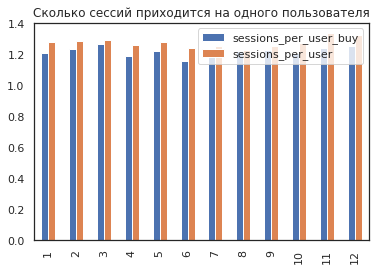

In [26]:
# сколько сессий приходится на одного пользователя, который заинтересован в покупке,  например, за месяц.
# Это хороший показатель регулярности использования приложения.
# Найти эту метрику просто — разделим число сессий на количество пользователей за период:

sessions_per_user_buy = orders.groupby('orders_month').agg({'uid': ['count','nunique']})
sessions_per_user_buy.columns = ['n_sessions_buy', 'n_users_buy']
sessions_per_user_buy['sessions_per_user_buy'] = sessions_per_user_buy['n_sessions_buy'] / sessions_per_user_buy['n_users_buy']
# print(sessions_per_user_buy.head(3))
sessions_per_user_buy = pd.concat([sessions_per_user_buy, sessions_per_user],  axis=1 )
display(sessions_per_user_buy.head(3))

sessions_per_user_buy[['sessions_per_user_buy', 'sessions_per_user' ]].plot(kind='bar')
plt.title('Сколько сессий приходится на одного пользователя')
plt.show()


#### ВЫВОД:
Сколько сессий приходится на одного пользователя, который заинтересован в покупке, например, за месяц. Это хороший показатель регулярности использования приложения. Найти эту метрику просто — разделим число сессий на количество пользователей за период. 

'Сколько времени проходит с первого визита до покупки'

count                      35662
mean     24 days 20:50:57.910380
std      59 days 11:36:56.932026
min              0 days 00:01:00
25%              0 days 00:05:00
50%              0 days 00:25:00
75%              7 days 00:01:00
max            363 days 23:03:00
Name: time_to_buy, dtype: object

'mode'

0   00:01:00
dtype: timedelta64[ns]

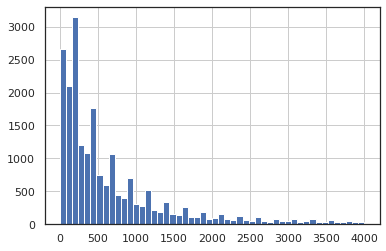

In [27]:
# Сколько времени проходит с первого визита до покупки:

report_orders_new['time_to_buy'] = ((report_orders_new['buy_ts'] - report_orders_new['first_visits_date']))
report_orders_new = report_orders_new.query('time_to_buy > "0 days 00:00:00"')
display('Сколько времени проходит с первого визита до покупки', report_orders_new['time_to_buy'].describe())
display('mode', report_orders_new['time_to_buy'].mode())
report_orders_new['time_to_buy'].dt.total_seconds().hist(bins = 50, range = (1, 4000 ))
plt.show()

#### Вывод:
С момента первого посещения сайта до покупки в среднем проходит 24 дня, и даже 1 год. Можно определить временные рамки от 5 мин  до 7дней.

In [28]:
# Сгруппируем датафрейм по пользователям и подсчитаем количество совершённых действий: покупок и средняя выручка:
count_orders_by_users = report_orders_new.groupby(['uid']).agg({'buy_ts':['count']})
report_orders_new['orders_week']  = report_orders_new['buy_ts'].dt.week
report_orders_new['orders_date'] = report_orders_new['buy_ts'].dt.date
dau_orders = report_orders_new.groupby('orders_date').agg({'uid': 'nunique', 'revenue':'sum'}).mean().round(2)
wau_orders = report_orders_new.groupby(['orders_week']).agg({'uid': 'nunique', 'revenue':'sum'}).mean().round(2)
mau_orders = report_orders_new.groupby(['month']).agg({'uid': 'nunique', 'revenue':'sum'}).mean().round(2)

display('dau_orders', dau_orders)
display('wau_orders', wau_orders)
display('mau_orders', mau_orders)



'dau_orders'

uid         98.24
revenue    619.57
dtype: float64

'wau_orders'

uid         684.75
revenue    4325.07
dtype: float64

'mau_orders'

uid         2971.83
revenue    18741.96
dtype: float64

,first_order_month,order_month,device,source_id,revenue,uid,revenue_per_user
0,2017-06-01,2017-06-01,desktop,1.0,920.30,131,7.025191
1,2017-06-01,2017-06-01,desktop,2.0,835.84,166,5.035181
2,2017-06-01,2017-06-01,desktop,3.0,2433.27,533,4.565235
3,2017-06-01,2017-06-01,desktop,4.0,1488.13,312,4.769647
4,2017-06-01,2017-06-01,desktop,5.0,1471.46,285,5.163018
...,...,...,...,...,...,...,...
817,2018-05-01,2018-05-01,touch,3.0,441.41,111,3.976667
818,2018-05-01,2018-05-01,touch,4.0,656.51,157,4.181592
819,2018-05-01,2018-05-01,touch,5.0,296.57,79,3.754051
820,2018-05-01,2018-05-01,touch,9.0,28.22,8,3.527500


224903.51

35662

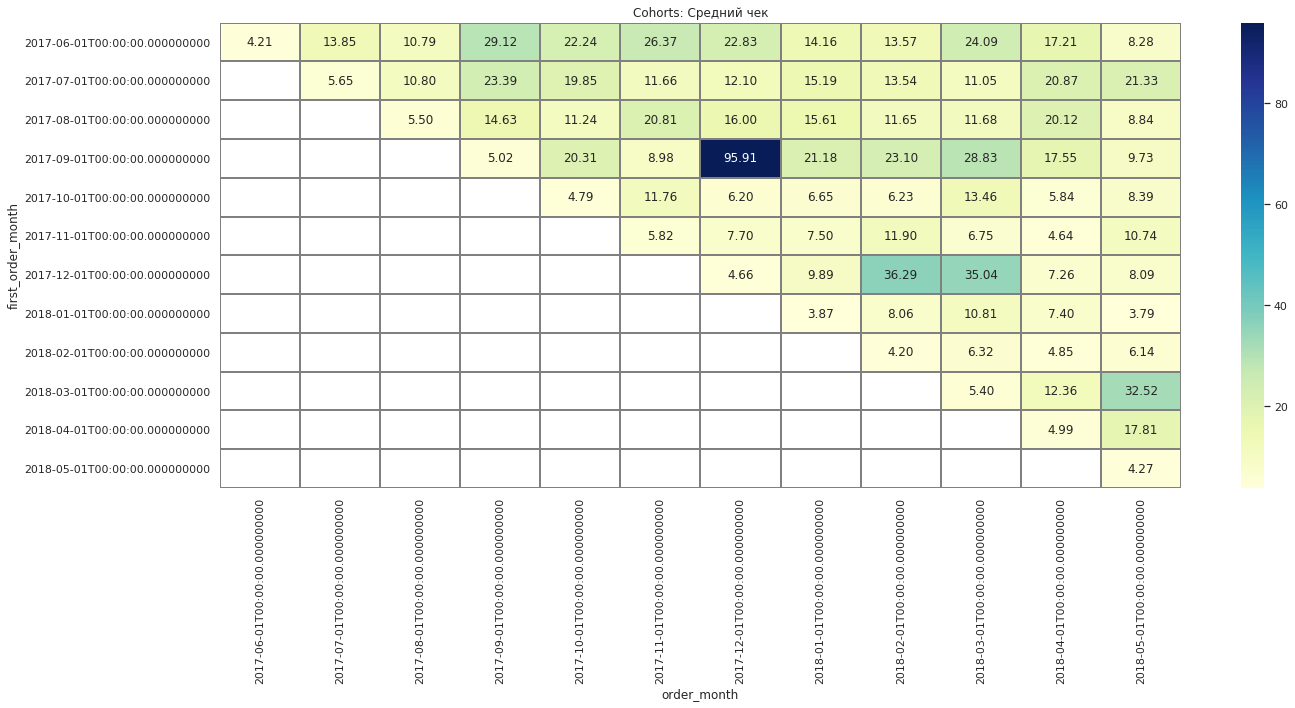

In [29]:
#  Расчет среднего чека от даты первой покупки

first_order_date = report_orders_new.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'

report_orders_new = report_orders_new.join(first_order_date, on='uid')
report_orders_new['first_order_date'] = pd.to_datetime(report_orders_new['first_order_date'])
report_orders_new['first_order_month'] = report_orders_new['first_order_date'].astype('datetime64[M]')


report_orders_new['order_month'] = report_orders_new['buy_ts'].astype('datetime64[M]')

orders_by_cohorts = report_orders_new.groupby(['first_order_month','order_month','device', 'source_id' ]).agg({'revenue':'sum','uid':'nunique'})
orders_by_cohorts = orders_by_cohorts.query('first_order_month != "2018-06-01"')

# Найдём средний чек покупателя revenue_per_user — разделим показатель revenue на customer_id:
orders_by_cohorts['revenue_per_user'] = (orders_by_cohorts['revenue'] / orders_by_cohorts['uid'])

# Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, 
# как изменяется средний чек с течением времени:
orders_by_cohorts = orders_by_cohorts.reset_index()
display(orders_by_cohorts)
display(orders_by_cohorts['revenue'].sum())
display(orders_by_cohorts['uid'].sum())
orders_per_users = orders_by_cohorts.pivot_table(index='first_order_month', 
                                                 values='revenue_per_user', 
                                                 columns='order_month', 
                                                 aggfunc='mean')

sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('Cohorts: Средний чек')
sns.heatmap(orders_per_users, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap="YlGnBu")
plt.tight_layout()
plt.show()



#### Выводы:

Прослеживается всплеск не только среди визитов покупателей, но и среднего чека на 3й месяц когорты. Как раз пользователи из 4й когорты перед Новым годом. Самая стабильная это 1 и 4 когорта.


,first_order_month,order_month,device,source_id,revenue,uid,revenue_per_user,cohort_lifetime
0,2017-06-01,2017-06-01,desktop,1.0,920.30,131,7.025191,0 days
1,2017-06-01,2017-06-01,desktop,2.0,835.84,166,5.035181,0 days
2,2017-06-01,2017-06-01,desktop,3.0,2433.27,533,4.565235,0 days


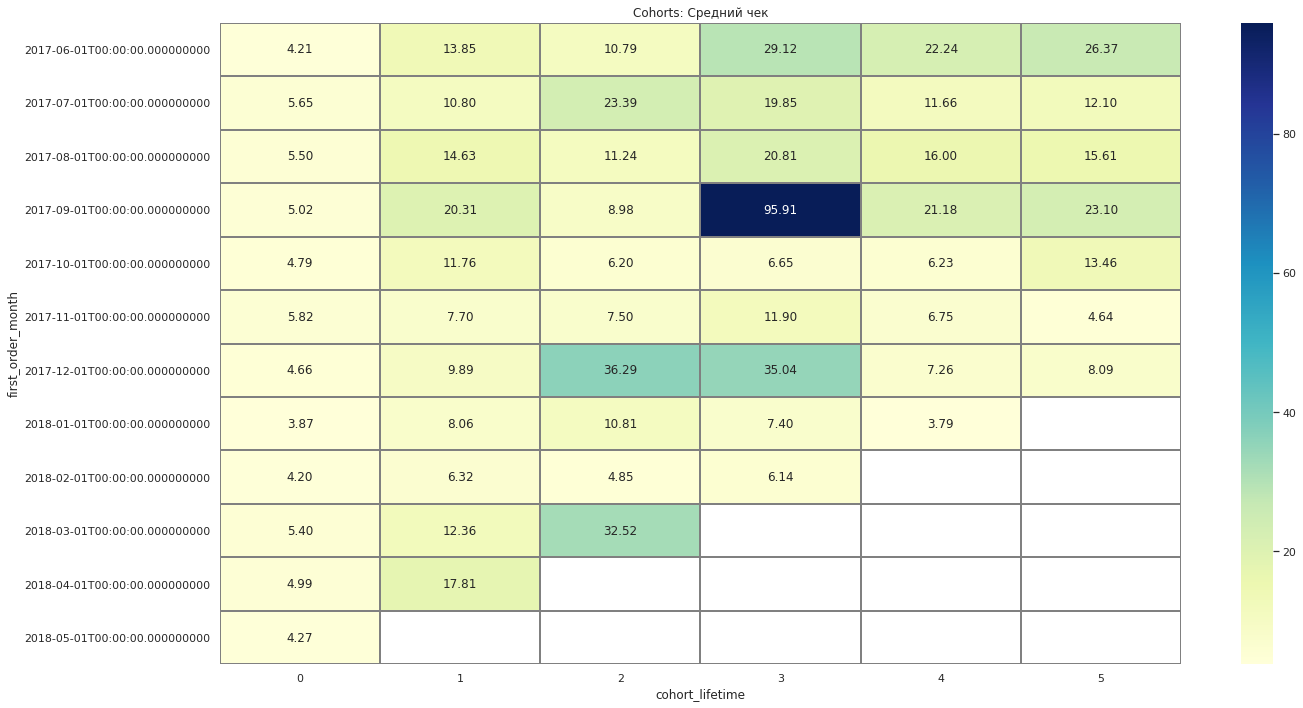

In [30]:
# Найдём lifetime когорты. Из месяца первого заказа order_month вычтем месяц когорты first_order_month:

orders_by_cohorts['cohort_lifetime'] = orders_by_cohorts['order_month'] - orders_by_cohorts['first_order_month']
display(orders_by_cohorts.head(3))


# Преобразуем этот тип в число месяцев, прошедших между датами.
# Для этого cohort_lifetime нужно разделить на константу np.timedelta64(1, 'M') —
# узнать, сколько величин длиной в 1 месяц содержится в cohort_lifetime.

orders_by_cohorts['cohort_lifetime'] = orders_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')

# Округлим значения столбца cohort_lifetime методом round(), а затем приведём их к целочисленному типу методом astype('int'):
orders_by_cohorts['cohort_lifetime'] = orders_by_cohorts['cohort_lifetime'].round().astype('int')
# orders_by_cohorts['first_order_month'] = orders_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

# Построим сводную таблицу изменения среднего чека, где в столбцах будет lifetime, а строках — когорты:

revenue_per_user_pivot = orders_by_cohorts.pivot_table(index='first_order_month',
                                                       columns='cohort_lifetime',
                                                       values='revenue_per_user', 
                                                       aggfunc='mean')
# display(revenue_per_user_pivot)
revenue_per_user_pivot = revenue_per_user_pivot[range(0,6)]


sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('Cohorts: Средний чек')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap="YlGnBu")
plt.tight_layout()
plt.show()



#### Вывод:
Определим срок lifetime 6мес.

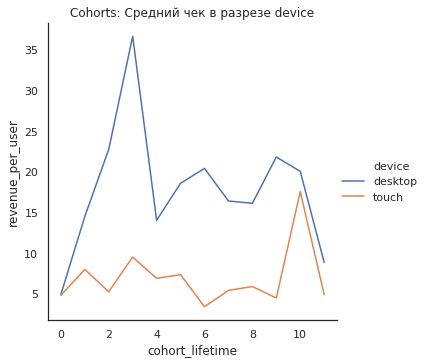

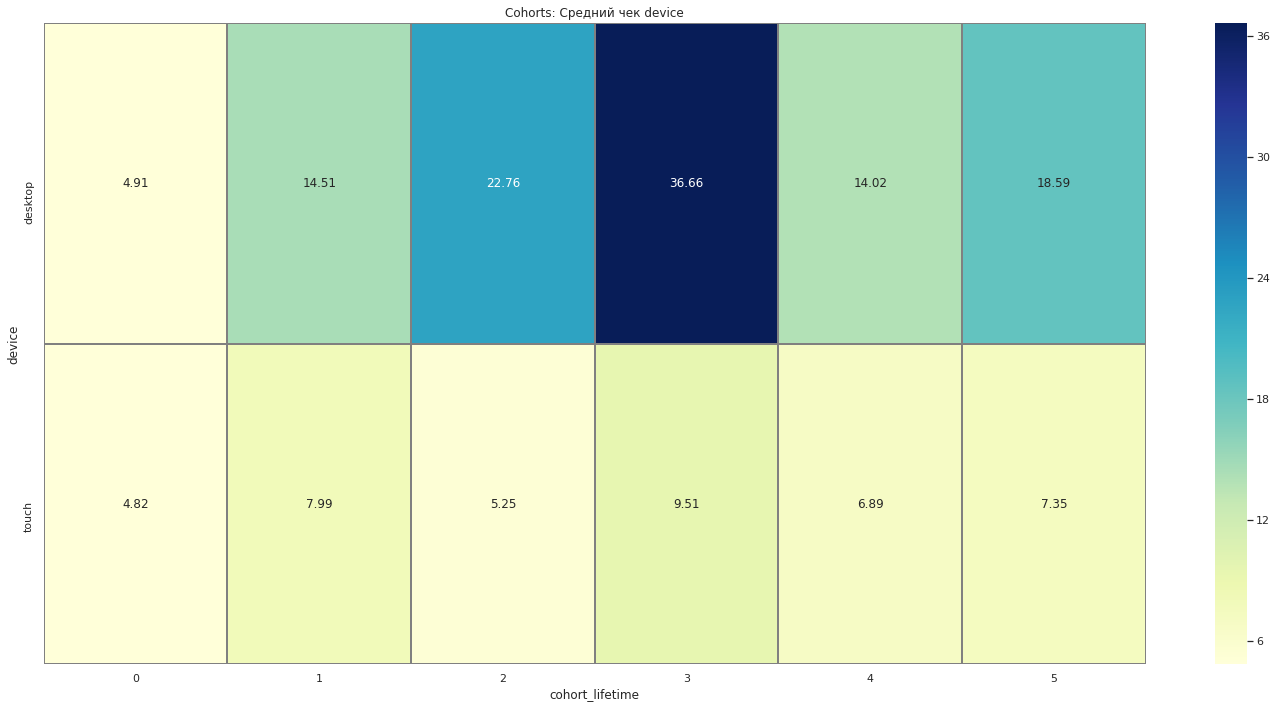

In [31]:
revenue_per_user_device = orders_by_cohorts.pivot_table(index='device',
                                                        columns='cohort_lifetime',
                                                        values='revenue_per_user', aggfunc='mean')

revenue_per_user_device = revenue_per_user_device[range(0,6)]
per_user_device = orders_by_cohorts.groupby(['cohort_lifetime', 'device'],  as_index=False).agg({'revenue_per_user': 'mean'})


sns.relplot(x="cohort_lifetime", y="revenue_per_user", hue="device", kind = 'line',  data=per_user_device)
plt.title('Cohorts: Средний чек в разрезе device')
plt.show()


sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('Cohorts: Средний чек device')
sns.heatmap(revenue_per_user_device, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap="YlGnBu")
plt.tight_layout()
plt.show()



#### Вывод:

Самый высокий средний чек (36 руб) как раз с desktop. Пики в 3 lifetime. 
Срок lifetime определим 6 мес.

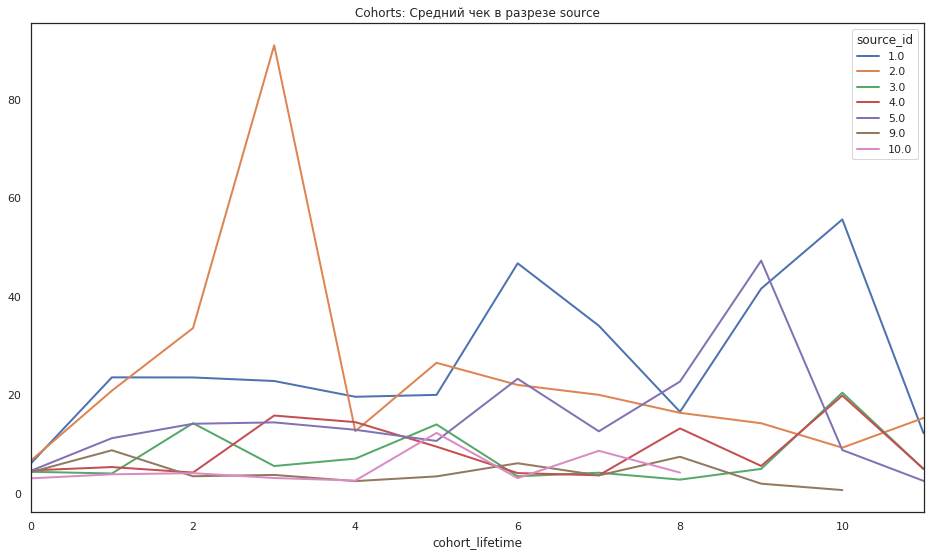

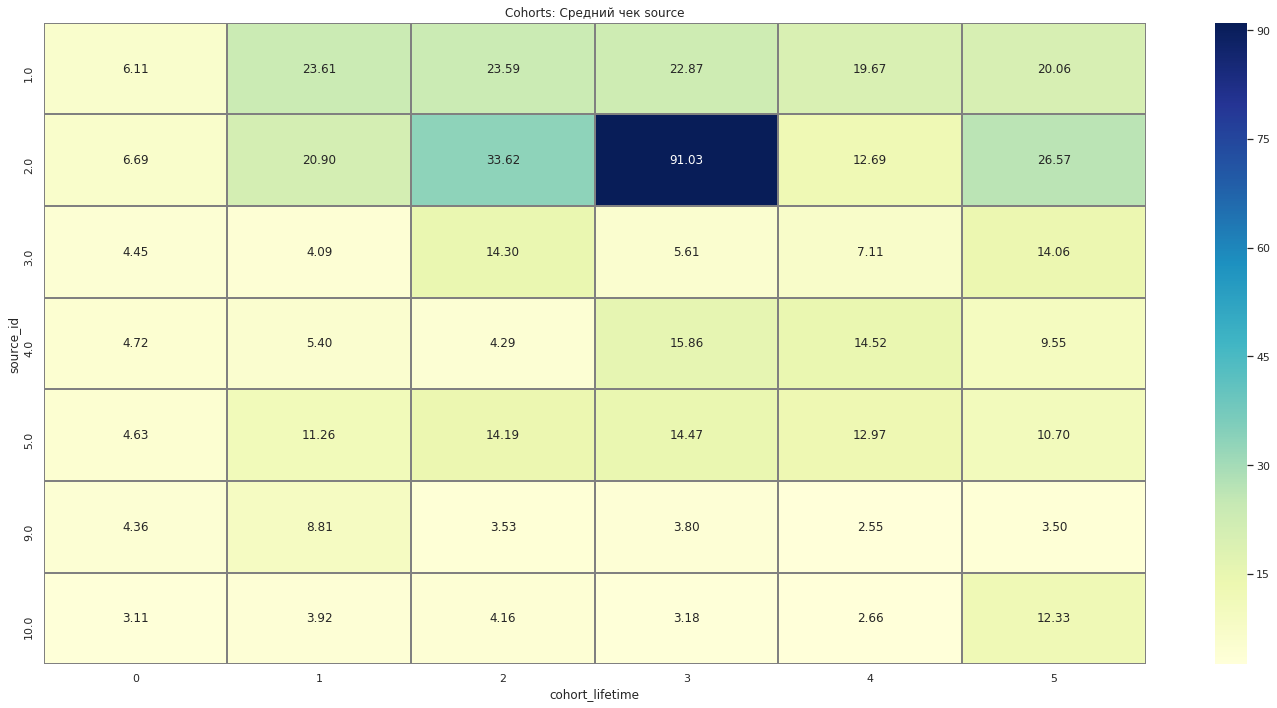

In [32]:
revenue_per_user_source = orders_by_cohorts.pivot_table(index='source_id',
                                                        columns='cohort_lifetime',
                                                        values='revenue_per_user', aggfunc='mean')

revenue_per_user_source = revenue_per_user_source[range(0,6)]
per_user_source = orders_by_cohorts.pivot_table(index = 'cohort_lifetime', 
                                                columns ='source_id',
                                                values ='revenue_per_user', 
                                                aggfunc = 'mean')


per_user_source.plot(figsize=(16, 9), title='source', linewidth = 2)
plt.title('Cohorts: Средний чек в разрезе source')
plt.show()


sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('Cohorts: Средний чек source')
sns.heatmap(revenue_per_user_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap="YlGnBu")
plt.tight_layout()
plt.show()

#### Вывод:
  Привлекали-привлекали пользователей из источника 3, их было много, но ничего не купили.. Зато пользователи, которые пришли из источников 1, 2 и 5 имеют высокие показатели на протяжении всего lifetime. Особенно высокий средний чек из 2го источника на 3й  lifetime, а из 1го источника 1-2 lifetime. 


• Сколько денег приносят? (LTV)-основной расчет в конце проекта

In [33]:
# Посмотрим на распределение дат заказов и расходов: Диапазон дат расходов совпадает с датами заказов.
display('Распределение дат заказов', report_orders_new['buy_ts'].describe())
display('Распределение дат расходов', costs['dt'].describe())


'Распределение дат заказов'

count                   35662
unique                  33358
top       2017-11-24 17:42:00
freq                        7
first     2017-06-01 00:10:00
last      2018-05-31 23:54:00
Name: buy_ts, dtype: object

'Распределение дат расходов'

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

#### Вывод:
Посмотрим на распределение дат заказов и расходов: Диапазон дат расходов совпадает с датами заказов. Старт на 1.06.2017, финиш на 31 мая 2018. Топ заказов пришлись на 2017-11-27, а топ расходов на 2018-03-03.

In [34]:
report_orders_new['month'] = report_orders_new['buy_ts'].astype('datetime64[M]')
costs['costs_month'] = costs['dt'].astype('datetime64[M]')

revenue_total = report_orders_new['revenue'].sum().astype('int')
revenue_device = report_orders_new.groupby('device')['revenue'].sum().astype('int')
revenue_source = report_orders_new.groupby('source_id')['revenue'].sum().astype('int')

print('revenue_total', revenue_total)
print('revenue_device', revenue_device)
print('revenue_source', revenue_source)


revenue_total 224903
revenue_device device
desktop    190810
touch       34092
Name: revenue, dtype: int64
revenue_source source_id
1.0     30446
2.0     58227
3.0     43205
4.0     47927
5.0     36580
9.0      4647
10.0     3868
Name: revenue, dtype: int64


#### ВЫвод:
Revenue device составляет 85% от общего revenue_total, остальные 15% это touch. ТОП 3 по источникам это 2, 4 и 3. 9 и 10 можно даже не рассматривать.  

In [35]:
costs_marketing = costs['costs'].sum().astype('int')
margin_rate = 1
orders_by_cohorts['gp'] = orders_by_cohorts['revenue'] * margin_rate
roi = (((revenue_total - costs_marketing) / costs_marketing)*100).round(2)

print('costs_marketing', costs_marketing)
print('roi', roi)



costs_marketing 329131
roi -31.67


#### Вывод:
Расходы на маркетинг составляют превышают Revenue на 46%. ROI -31,67%!!! Расходы на маркетинг не окупились.

'monthly_costs'

,costs_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


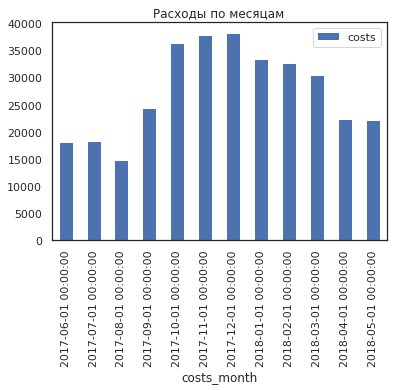

In [36]:
# Посчитаем остальные когорты и посмотрим, сколько месяцев нужно каждой когорте,
# чтобы окупить маркетинговые затраты. Считаем расходы за месяц

monthly_costs = costs.groupby('costs_month').sum()
monthly_costs= monthly_costs.reset_index()
display('monthly_costs', monthly_costs)
monthly_costs.plot( kind='bar', y='costs', x='costs_month')
plt.title('Расходы по месяцам')
plt.show()


#### Вывод:
Пик расходов приходится на окт-дек 2017 мес.

## Маркетинг
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)

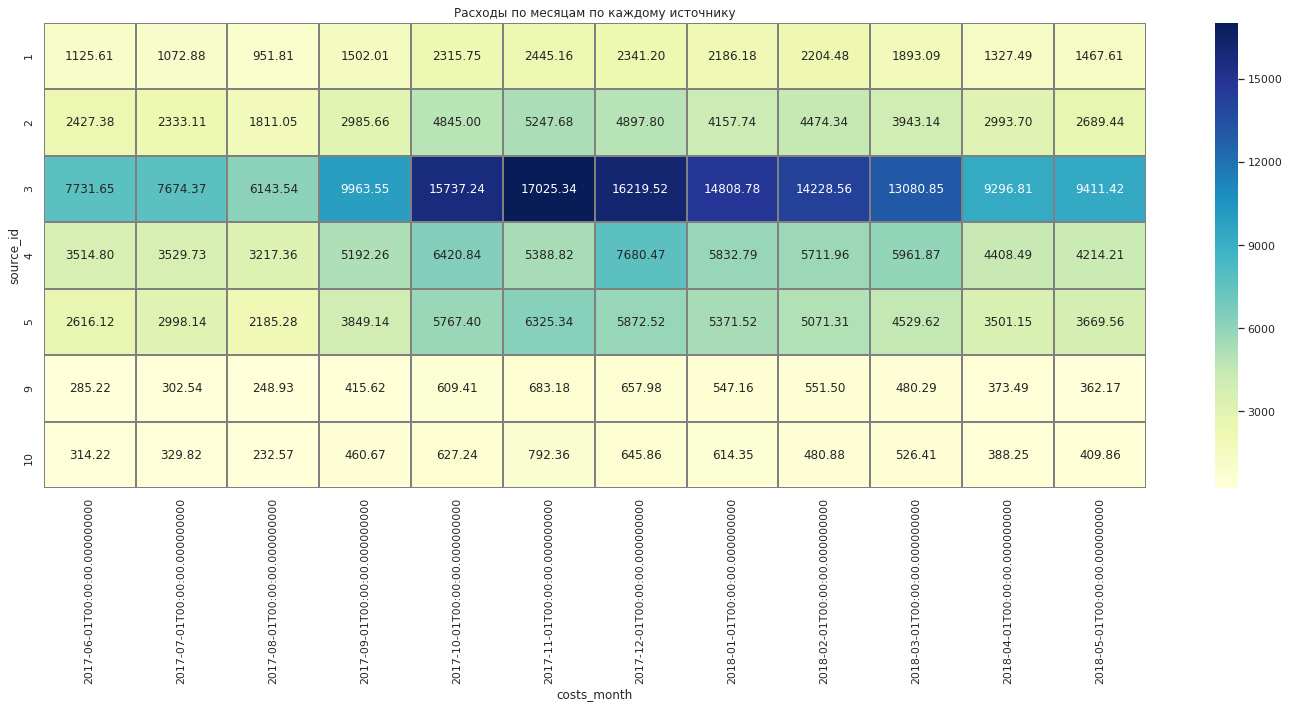

In [37]:
# Расходы по источникам:

source_costs = costs.pivot_table(index='source_id', values='costs', columns='costs_month', aggfunc='sum')
# display('source_costs по месяцам', source_costs)
sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('Расходы по месяцам по каждому источнику')
sns.heatmap(source_costs, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap="YlGnBu")
plt.tight_layout()
plt.show()



#### Вывод:
Самый затратный источник это 3, потом идет 4 и 5.

In [38]:
#  Какие расходы в день, неделю, месяц?
costs['week'] = costs['dt'].dt.week
costs['month'] = costs['dt'].dt.month
costs['day'] = costs['dt'].dt.date

dau_costs = costs.groupby('day').agg({'costs': 'sum'}).mean()
wau_costs = costs.groupby('week').agg({'costs': 'sum'}).mean()
mau_costs = costs.groupby('month').agg({'costs': 'sum'}).mean()

print('DAUcosts', int(dau_costs))
print('WAUcosts', int(wau_costs))
print('MAUcosts', int(mau_costs))



DAUcosts 904
WAUcosts 6329
MAUcosts 27427


In [39]:
first_costs_date = costs.groupby(['source_id'])['dt'].min()
first_costs_date.name = 'first_costs_date'
costs = costs.join(first_costs_date, on='source_id')
costs['first_costs_date'] = pd.to_datetime(costs['first_costs_date'])
costs['first_costs_month'] = costs['first_costs_date'].astype('datetime64[M]')
# costs['first_costs_month'] = costs['first_costs_month'].dt.strftime('%Y-%m')

costs_cohorts = costs.groupby(['first_costs_month','costs_month', 'source_id']).agg({'costs':'sum'})

# Построим сводную таблицу изменения расходов в когортах по месяцу:
costs_cohorts = costs_cohorts.reset_index()

# Найдём lifetime когорты. Из месяца первого расхода сщыеы_month вычтем месяц когорты first_costs_month:

costs_cohorts['lifetime'] = costs_cohorts['costs_month'] - costs_cohorts['first_costs_month']

# Преобразуем этот тип в число месяцев, прошедших между датами.
# Для этого cohort_lifetime нужно разделить на константу np.timedelta64(1, 'M') —
# узнать, сколько величин длиной в 1 месяц содержится в cohort_lifetime.

costs_cohorts['lifetime'] = costs_cohorts['lifetime'] / np.timedelta64(1,'M')

# Округлим значения столбца cohort_lifetime методом round(), а затем приведём их к целочисленному типу методом astype('int'):
costs_cohorts['lifetime'] = costs_cohorts['lifetime'].round().astype('int')

# Построим сводную таблицу изменения расходов, где в столбцах будет lifetime, а строках — когорты:

costs_source_pivot = costs_cohorts.pivot_table(index='source_id',columns='lifetime',values='costs',aggfunc='sum')
display('Сводная таблица изменения расходов, по "lifetime"', costs_source_pivot)



'Сводная таблица изменения расходов, по "lifetime"'

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


#### ВЫвод:
Данные таблицы совпадают с данными по расходам по месяцам и источнику.

In [40]:
# Строим профили пользователей:

users = (visits_copy.sort_values(by = ['uid', 'start_ts'])
         .groupby('uid').agg({'start_ts':'first', 'source_id': 'first', 'device':'first'})
         .rename(columns = {'start_ts' : 'acquisition_ts'}))

users['acqusition_date'] = users['acquisition_ts'].dt.date
users['acquisition_month'] = users['acquisition_ts'].astype('datetime64[M]')
costs.rename(columns = {'dt':'acqusition_date'}, inplace=True)

users = (users.reset_index()
         .set_index(['source_id', 'acqusition_date'])
         .join(costs.set_index(['source_id','acqusition_date']), how = 'left'))

# Добавляем стоимость приобретения уникального пользователя

user_cost = (users.groupby(['source_id', 'acqusition_date'])
             .agg({'device': 'count', 'costs': 'max'})
             .rename(columns = {'device': 'users'}))

user_cost['acqusition_cost'] = user_cost['costs'] / user_cost['users']

users = users.join(user_cost[['acqusition_cost']], how = 'left')

users = users.reset_index().set_index('uid')[['acquisition_ts', 'acqusition_date', 'acquisition_month', 'source_id', 'device', 'acqusition_cost']]

display(users.head())
display(users.shape[0], len(visits['uid'].unique()), users['acqusition_cost'].sum(), costs['costs'].sum())


,acquisition_ts,acqusition_date,acquisition_month,source_id,device,acqusition_cost
uid,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.6
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.6
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.6
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.6


228169

228139

329066.4799999999

329131.62

In [41]:
# Для каждого пользователя считаем основным первый источник входа и устройство. Интревал-календарный месяц.
visits_copy['visits_month']=visits_copy['start_ts'].astype('datetime64[M]')
report=(visits_copy.sort_values(by=['uid', 'start_ts'])
        .groupby(['uid','visits_month'])
        .agg({'source_id':'first', 'device':'first'})).reset_index()

# Присоединим покупки
orders_copy['orders_month']=orders_copy['buy_ts'].astype('datetime64[M]')
report = visits_copy.merge(orders_copy
                .groupby(['uid', 'orders_month'])
                .agg({'revenue':'sum', 'buy_ts':'count'}), 
                left_on = ['uid', 'visits_month'], 
                right_on = ['uid', 'orders_month'], how = 'left').rename(columns= {'buy_ts':'orders'})
display(report.head())

report = report.groupby(['visits_month', 'device']).agg({'uid':'nunique', 'orders':'sum', 'revenue':['count','sum']})
report.columns = ['MAU', 'orders', 'paying_MAU', 'revenue']
display(report.head())

,device,end_ts,source_id,start_ts,uid,visits_month,revenue,orders
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,NaN,NaN
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,NaN,NaN
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,NaN,NaN
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,NaN,NaN
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,NaN,NaN


MAU  orders  paying_MAU   revenue
visits_month device                                      
2017-06-01   desktop   9761  4345.0        2786  26319.70
             touch     3655   583.0         480   1980.78
2017-07-01   desktop  10145  5354.0        2537  34717.74
             touch     4223   831.0         659   4771.50
2017-08-01   desktop   8611  5393.0        1907  30443.10

In [42]:
# i* платящий пользователь или нет
users = users.join(orders_copy.groupby('uid').agg({'buy_ts':'min'})
                   .rename(columns = {'buy_ts':'first_purchase_dt'}), how = 'left')
users['payer'] = ~users['first_purchase_dt'].isna()

display('платящий пользователь или нет', users.groupby('payer')['source_id'].count())

'платящий пользователь или нет'

payer
False    191646
True      36523
Name: source_id, dtype: int64

#### ВЫвод:
Всего пользователей 228169, из них только 16% платят.

In [43]:
# Строим профили платящих пользователей. Их стоимость привлечения отличается от неплатящих пользователей.
paying_users = (visits_copy[visits_copy['uid'].isin(orders['uid'].unique())]
               .sort_values(by = ['uid', 'start_ts']).groupby('uid')
                .agg({'start_ts':'first','source_id':'first','device':'first' })
                .rename(columns = {'start_ts':'acqusition_ts'}))

paying_users['acqusition_date'] = paying_users['acqusition_ts'].dt.date
paying_users['acqusition_month'] = paying_users['acqusition_ts'].astype('datetime64[M]')
# display(paying_users.head())
# display(costs.head())
paying_users = (paying_users.reset_index().set_index(['source_id', 'acqusition_date'])
                .join(costs.set_index(['source_id', 'acqusition_date']), how='left'))
# paying_users.drop(['index'], axis=1, inplace=True)
display(paying_users.head())

uid       acqusition_ts   device  \
source_id acqusition_date                                                     
1         2017-06-01        469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01       1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01       1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01       2050423809815667474 2017-06-01 10:36:00  desktop   
          2017-06-01       3520273333047097992 2017-06-01 20:08:00  desktop   

                          acqusition_month  costs costs_month  week  month  \
source_id acqusition_date                                                    
1         2017-06-01            2017-06-01   75.2  2017-06-01  22.0    6.0   
          2017-06-01            2017-06-01   75.2  2017-06-01  22.0    6.0   
          2017-06-01            2017-06-01   75.2  2017-06-01  22.0    6.0   
          2017-06-01            2017-06-01   75.2  2017-06-01  22.0    6.0   
          2017-06-01            2017-06-01   75.2  2017-06-01  22.0    6.0   

                                  day first_costs_date first_costs_month  
source_id acqusition_date                                                 
1         2017-06-01       2017-06-01       2017-06-01        2017-06-01  
          2017-06-01       2017-06-01       2017-06-01        2017-06-01  
          2017-06-01       2017-06-01       2017-06-01        2017-06-01  
          2017-06-01       2017-06-01       2017-06-01        2017-06-01  
          2017-06-01       2017-06-01       2017-06-01        2017-06-01

In [44]:
#Добавим стоимость приобретения уникального пользователя, для этого сгруппируем по пользователям и разделим стоимость на количесвто.

user_cost =(paying_users.groupby(['source_id', 'acqusition_date']).agg({'device':'count', 'costs':'max'})
                        .rename(columns={'device':'users'}))
user_cost['payer_acqusition_cost'] = user_cost['costs'] / user_cost['users']
display(user_cost.head())
display(paying_users.head())
paying_users = paying_users.join(user_cost[['payer_acqusition_cost']], how = 'left')
paying_users = paying_users.reset_index().set_index('uid')[['acqusition_ts', 'acqusition_date', 'acqusition_month','source_id', 'device', 'payer_acqusition_cost']]

display(paying_users.head())  
display(paying_users.shape[0], len(orders['uid'].unique()), paying_users['payer_acqusition_cost'].sum(), costs['costs'].sum())


users  costs  payer_acqusition_cost
source_id acqusition_date                                     
1         2017-06-01          24  75.20               3.133333
          2017-06-02          12  62.25               5.187500
          2017-06-03           8  36.53               4.566250
          2017-06-04           6  55.00               9.166667
          2017-06-05          20  57.08               2.854000

uid       acqusition_ts   device  \
source_id acqusition_date                                                     
1         2017-06-01        469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01       1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01       1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01       2050423809815667474 2017-06-01 10:36:00  desktop   
          2017-06-01       3520273333047097992 2017-06-01 20:08:00  desktop   

                          acqusition_month  costs costs_month  week  month  \
source_id acqusition_date                                                    
1         2017-06-01            2017-06-01   75.2  2017-06-01  22.0    6.0   
          2017-06-01            2017-06-01   75.2  2017-06-01  22.0    6.0   
          2017-06-01            2017-06-01   75.2  2017-06-01  22.0    6.0   
          2017-06-01            2017-06-01   75.2  2017-06-01  22.0    6.0   
          2017-06-01            2017-06-01   75.2  2017-06-01  22.0    6.0   

                                  day first_costs_date first_costs_month  
source_id acqusition_date                                                 
1         2017-06-01       2017-06-01       2017-06-01        2017-06-01  
          2017-06-01       2017-06-01       2017-06-01        2017-06-01  
          2017-06-01       2017-06-01       2017-06-01        2017-06-01  
          2017-06-01       2017-06-01       2017-06-01        2017-06-01  
          2017-06-01       2017-06-01       2017-06-01        2017-06-01

,acqusition_ts,acqusition_date,acqusition_month,source_id,device,payer_acqusition_cost
uid,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,3.133333
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,3.133333
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,3.133333
2050423809815667474,2017-06-01 10:36:00,2017-06-01,2017-06-01,1,desktop,3.133333
3520273333047097992,2017-06-01 20:08:00,2017-06-01,2017-06-01,1,desktop,3.133333


36523

36523

327215.46

329131.62

In [45]:
# LTV для плательщиков

current_users = users.query('payer==True')
# display(users.head())
# display(current_users.head())
# display(paying_users.head())
# display(user_cost.head())
current_users['acqusition_cost'] =paying_users['payer_acqusition_cost']
# display(current_users.head())
# расчитываем когорты

cohorts = (current_users.groupby('acquisition_month')
                  .agg({'payer':'count','acqusition_cost':'sum' })
                  .rename(columns ={'payer':'cohort_size'}))

cohorts['cac'] = (cohorts['acqusition_cost'] / cohorts['cohort_size']).round(2)
display(cohorts)
    
cohorts_source = (current_users.groupby('source_id')
                  .agg({'payer':'count','acqusition_cost':'sum' })
                  .rename(columns ={'payer':'cohort_size'}))

cohorts_source['cac'] = (cohorts_source['acqusition_cost'] / cohorts_source['cohort_size']).round(2)
display(cohorts_source)

cohorts_device = (current_users.groupby('device')
                  .agg({'payer':'count','acqusition_cost':'sum' })
                  .rename(columns ={'payer':'cohort_size'}))

cohorts_device['cac'] = (cohorts_device['acqusition_cost'] / cohorts_device['cohort_size']).round(2)
display(cohorts_device)



# display(cohorts_source['acqusition_cost'].sum(), cohorts_source['cohort_size'].sum())


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,cohort_size,acqusition_cost,cac
acquisition_month,,,
2017-06-01,2923,17920.90,6.13
2017-07-01,2458,18066.85,7.35
2017-08-01,1721,14570.37,8.47
2017-09-01,3058,24257.96,7.93
2017-10-01,4678,36288.11,7.76
2017-11-01,4262,37813.95,8.87
2017-12-01,4074,38131.00,9.36
2018-01-01,3119,33282.67,10.67
2018-02-01,3186,32541.23,10.21


,cohort_size,acqusition_cost,cac
source_id,,,
1,2899,20790.03,7.17
2,3506,42690.36,12.18
3,10473,141321.63,13.49
4,10296,61057.91,5.93
5,6931,51756.40,7.47
7,1,0.00,0.00
9,1088,4197.85,3.86
10,1329,5401.28,4.06


,cohort_size,acqusition_cost,cac
device,,,
desktop,29211,263183.050559,9.01
touch,7312,64032.409441,8.76


#### Выводы:

Самая высокая стоимость приобретения клиентов янв-апр 2018, самая минимальная июнь-июль 2017. По источникам самые дорогие пользователи из 2 и 3 источника.Самый выгодный источник-4: много пользователей и низкая стоимость привлечения.

In [46]:
# Считаем LTV, ROMI по месяцам, источникам и устройствам. Срок 6 мес.


ltv = orders_copy.set_index('uid').join(users, how = 'left')[['acquisition_month', 'source_id', 'device', 'orders_month', 'revenue']]

ltv['lifetime'] = ((ltv['orders_month'] - ltv['acquisition_month'])/np.timedelta64(1,'M')).round().astype('int')

ltv_month = ltv.groupby(['acquisition_month'] + ['lifetime']).agg({'revenue':'sum'}).reset_index()
ltv_month = pd.pivot_table(ltv_month, index='acquisition_month', columns = 'lifetime', values='revenue', aggfunc = 'sum')
ltv_month = ltv_month.cumsum(axis =1)
ltv_month = cohorts[['cohort_size']].join(ltv_month)
# display(ltv)
ltv_month = ltv_month.div(ltv_month['cohort_size'], axis =0).drop(columns = ['cohort_size']).round(2)
display("LTV ", ltv_month[range(0,6)])
cohorts = cohorts[['cac']].join(ltv_month).round(2)
# display(cohorts)
romi = cohorts.div(cohorts['cac'],axis =0).drop(columns = ['cac']).round(2)
display("ROMI", romi[range(0,6)])


ltv_source = ltv.groupby(['source_id'] + ['lifetime']).agg({'revenue':'sum'}).reset_index()
ltv_source = pd.pivot_table(ltv_source, index='source_id', columns = 'lifetime', values='revenue', aggfunc = 'sum')
ltv_source = ltv_source.cumsum(axis =1)
ltv_source = cohorts_source[['cohort_size']].join(ltv_source)
# display(ltv)
ltv_source = ltv_source.div(ltv_source['cohort_size'], axis =0).drop(columns = ['cohort_size']).round(2)
display("LTV source ", ltv_source[range(0,6)])
cohorts_source = cohorts_source[['cac']].join(ltv_source).round(2)
# display(cohorts)
romi_source = cohorts_source.div(cohorts_source['cac'],axis =0).drop(columns = ['cac']).round(2)
display("ROMI source", romi_source[range(0,6)])


ltv_device = ltv.groupby(['device'] + ['lifetime']).agg({'revenue':'sum'}).reset_index()
ltv_device = pd.pivot_table(ltv_device, index='device', columns = 'lifetime', values='revenue', aggfunc = 'sum')
ltv_device = ltv_device.cumsum(axis =1)
ltv_device = cohorts_device[['cohort_size']].join(ltv_device)
# display(ltv)
ltv_device = ltv_device.div(ltv_device['cohort_size'], axis =0).drop(columns = ['cohort_size']).round(2)
display("LTV device ", ltv_device[range(0,6)])
cohorts_device = cohorts_device[['cac']].join(ltv_device).round(2)
# display(cohorts)
romi_device = cohorts_device.div(cohorts_device['cac'],axis =0).drop(columns = ['cac']).round(2)
display("ROMI device", romi_device[range(0,6)])




'LTV '

,0,1,2,3,4,5
acquisition_month,,,,,,
2017-06-01,3.27,4.18,4.68,6.01,7.36,8.32
2017-07-01,4.02,4.45,4.90,5.30,5.64,5.97
2017-08-01,3.62,4.20,4.78,5.33,5.80,6.11
2017-09-01,4.04,5.25,5.94,9.35,9.78,10.40
2017-10-01,3.93,4.74,5.02,5.25,5.47,5.69
2017-11-01,3.88,4.50,4.82,5.14,5.40,5.57
2017-12-01,4.14,4.56,5.60,6.85,7.21,7.65
2018-01-01,3.40,4.02,4.40,4.49,4.66,NaN
2018-02-01,3.61,4.24,4.44,4.73,NaN,NaN


'ROMI'

,0,1,2,3,4,5
acquisition_month,,,,,,
2017-06-01,0.53,0.68,0.76,0.98,1.20,1.36
2017-07-01,0.55,0.61,0.67,0.72,0.77,0.81
2017-08-01,0.43,0.50,0.56,0.63,0.68,0.72
2017-09-01,0.51,0.66,0.75,1.18,1.23,1.31
2017-10-01,0.51,0.61,0.65,0.68,0.70,0.73
2017-11-01,0.44,0.51,0.54,0.58,0.61,0.63
2017-12-01,0.44,0.49,0.60,0.73,0.77,0.82
2018-01-01,0.32,0.38,0.41,0.42,0.44,NaN
2018-02-01,0.35,0.42,0.43,0.46,NaN,NaN


'LTV source '

,0,1,2,3,4,5
source_id,,,,,,
1,5.01,5.91,6.53,7.48,8.06,8.44
2,5.11,6.84,8.56,10.41,11.32,12.03
3,3.60,4.17,4.40,4.62,4.81,4.94
4,3.64,4.07,4.28,4.48,4.65,4.86
5,4.15,4.65,4.94,6.51,6.76,7.07
7,1.22,NaN,NaN,NaN,NaN,NaN
9,2.18,2.76,3.29,3.76,4.18,4.38
10,2.67,2.90,3.00,3.06,3.19,3.25


'ROMI source'

,0,1,2,3,4,5
source_id,,,,,,
1,0.70,0.82,0.91,1.04,1.12,1.18
2,0.42,0.56,0.70,0.85,0.93,0.99
3,0.27,0.31,0.33,0.34,0.36,0.37
4,0.61,0.69,0.72,0.76,0.78,0.82
5,0.56,0.62,0.66,0.87,0.90,0.95
7,inf,NaN,NaN,NaN,NaN,NaN
9,0.56,0.72,0.85,0.97,1.08,1.13
10,0.66,0.71,0.74,0.75,0.79,0.80


'LTV device '

,0,1,2,3,4,5
device,,,,,,
desktop,4.01,4.64,5.09,5.89,6.22,6.51
touch,3.44,4.12,4.41,4.63,4.80,4.97


'ROMI device'

,0,1,2,3,4,5
device,,,,,,
desktop,0.45,0.51,0.56,0.65,0.69,0.72
touch,0.39,0.47,0.50,0.53,0.55,0.57


#### Вывод:

Самый высокий LTV у пользователей 4 и 1 когорты. ROMI этих когорт выходит на окупаемость уже на 4 и 5й месяц соответственно. По источникам 1 и 2 -это пользователи с наибольшим LTV. Их  ROMI на 3 и 7й соотвественно выходит на окупаемость.

In [47]:
# Посчитаем расходы по источникам и device.

users_costs_device = users.reset_index().groupby('device')['acqusition_cost'].sum().astype('int')
users_costs_sourse = users.reset_index().groupby('source_id')['acqusition_cost'].sum().astype('int')

display('users_costs_device', users_costs_device)
display('users_costs_sourse', users_costs_sourse)



'users_costs_device'

device
desktop    235065
touch       94000
Name: acqusition_cost, dtype: int64

'users_costs_sourse'

source_id
1      20833
2      42806
3     141321
4      61073
5      51756
6          0
7          0
9       5454
10      5821
Name: acqusition_cost, dtype: int64

#### Вывод:

- Сколько денег потратили? Всего / на каждый источник 

Всего потрачено на маркетинг:329 131руб.
Топ 3 расходов по источникам: source-3-141 321руб, 4 -61 073руб, 5- 51 756руб.
На desktop   пришлось 72% расходов, и 28 % на touch. На 3й источник приходится 43% от общей суммы расходов 141 321руб, на втором 4 и 5 источник.

In [48]:
# Считаем ROI по источникам и девайсам.
roi_device = pd.concat([revenue_device.reset_index(), users_costs_device.reset_index()],  axis=1 )
roi_source = pd.concat([revenue_source.reset_index(), users_costs_sourse.reset_index()],  axis=1 )
roi_device['roi_device'] = ((roi_device['revenue'] - roi_device['acqusition_cost']) / roi_device['acqusition_cost']).map(lambda x: "{0:.1%}".format(x))
roi_source['roi_source'] = ((roi_source['revenue'] - roi_source['acqusition_cost']) / roi_source['acqusition_cost']).map(lambda x: "{0:.1%}".format(x))

display('roi_device', roi_device)
display('roi_source', roi_source)




'roi_device'

,device,revenue,device,acqusition_cost,roi_device
0,desktop,190810,desktop,235065,-18.8%
1,touch,34092,touch,94000,-63.7%


'roi_source'

,source_id,revenue,source_id,acqusition_cost,roi_source
0,1.0,30446.0,1,20833,46.1%
1,2.0,58227.0,2,42806,36.0%
2,3.0,43205.0,3,141321,-69.4%
3,4.0,47927.0,4,61073,-21.5%
4,5.0,36580.0,5,51756,-29.3%
5,9.0,4647.0,6,0,inf%
6,10.0,3868.0,7,0,inf%
7,NaN,NaN,9,5454,nan%
8,NaN,NaN,10,5821,nan%


#### Вывод:
ROI положительный только у 1 и 2 источника, это конечно радует, что расходы окупились. Самый неокупаемый источник-3. ROI device тоже отрицательный, но быстрее окупится desktop.

## ОБЩИЙ ВЫВОД:

### Куда и сколько им стоит вкладывать денег?
### Какие источники/платформы вы бы порекомендовали?
### Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?

### Начнем с общих выводов:

- revenue_total 252 057
- costs_marketing 329 131
- roi 2015%
- количество пользователей 228 169
- количество визитов 359 400
- количество заказов 50 415/36 523(уникальных пользователей)

На каждого пользователя приходится по 1,57 визита. Всего визитов 359 400, но только каждый 7ой заканчивается покупкой. Из всех пользователей(228 169), только 16% платят (36 523). 
В среднем сессия длится 11,54 мин, но и может достигать максисму в 11часов51мин. Но это больше исключение. От 2 до 15 мин это нормальное время для сессии.
С момента первого посещения сайта до покупки в среднем проходит 24 дня, и даже 1 год. Можно определить временные рамки от 5 мин  до 7дней. 
Как часто люди возвращаются? Для этого сделали когортный анализ и посчитали Retention Rate. Пользователи, которые присоединились в четвертую, пятую и шестую когорту. Они имеею более высокий процент удержания в первый месяц 7,8-8%, чем пользователи, других когорт, но затем пользователи быстрее покидают эти когорты, чем например пользователи 1, 2 и 3 когорты. Как раз, скоро Новый год и пользователи дольше остаются. В первый месяц возвращается не более 7,5-8%, во второй уже 5-6%.
Самый высокий %=14-15% возвращения клиентов, это пользователи из 1,2 и 9 источников. Интересно, что больше всего визитов было из 3го источника, но клиенты вернулись всего 4% в первый месяц. Что это за источник...

Всего 11-12% заказов по отношению к визитам. При этом средние расходы день/неделя/месяц превышают доходы.

- _DAUvisits 907 / WAUvisits 5824 / MAUvisits 23225
- _dau_orders 98 /wau_orders 684 / mau_orders 2971
- _dau_revenue 619 / wau_revenue 4 325/ mau_revenue 18 741
- _DAUcosts 904 / WAUcosts 6 329 / MAUcosts 27 427

### Посмотрим результаты в разрезе device:

|device| revenue| 
|:----|:---:|
desktop|    190 810
touch |      34 092


|device| roi|
|:----|:---:|
desktop|   -18.80%
touch| -63.7%


|device |costs|
|:----|:---:|
desktop|    235 065
touch  |     94 000


Расходы по desktop и touch 18% превысили доходы. Видно, что и roi desktop в 3 раз выше, чем у touch, но все равно отрицательный. Соответственно для Афиши выгодно использовать desktop.

### Посмотрим результаты в разрезе источников(source): возьмем ТОП 5

|source  |revenue_source|  cac | roi_source | costs  |   % расход / доход
|:----|:---:| ---:|:---:|:---:|:---
|1 | 30 446    | 7.17     |   46%   |  20 833 |    68%
|2 |58 227       | 12.18  | 36%       |42 806   | 73%
|3 | 43 205      | 13.49    | -69,4%        |141 321  |   320%
|4 | 47 927      |  5.93     | -21,5%       |61 073   |  127%
|5 |36 580      |  7.47    | -29,3      |51 756   |  141%



Из этой таблицы видно, что самый затратный источник это №3, его расходы превышают доходы в три раза, потом идет 4 и 5.
Выгодно сконцентрировать внимание на источниках 2 источнике

Самый популярный источник из которого переходят №1, 2 и 5. Можно наблюдать всплеск визитов перед Новым годом, ноябрь-декабрь, март, сентябрь. Привлекали-привлекали пользователей из источника 3, их было много, но ничего не купили.. Зато пользователи, которые пришли из источников 1, 2 и 5 имеют высокие показатели на протяжении всего lifetime. Особенно высокий средний чек из 2го источника на 3й lifetime, а из 1го источника 1-2 lifetime.

Прослеживается всплеск не только среди визитов покупателей, но и среднего чека на 3й месяц когорты. Как раз пользователи из 4й когорты перед Новым годом. Самая стабильная это 1 и 4 когорта.

Revenue device составляет 85% от общего revenue_total, остальные 15% это touch. ТОП 3 по источникам это 2, 4 и 3. 9 и 10 можно даже не рассматривать. 

Пользователи, которые присоединились в четвертую, пятую и шестую когорту. Они имеею более высокий процент удержания в первый месяц 7,8-8%, чем пользователи, других когорт, но затем пользователи быстрее покидают эти когорты, чем например пользователи 1, 2 и 3 когорты. Как раз, скоро Новый год и пользователи дольше остаются. В первый месяц возвращается не более 7,5-8%, во второй уже 5-6%.

Посмотрим на распределение дат заказов и расходов: Диапазон дат расходов совпадает с датами заказов. Старт на 1.06.2017, финиш на 31 мая 2018. Топ заказов пришлись на 2017-11-27, а топ расходов на 2018-03-03.

Расходы на маркетинг составляют превышают Revenue на 46%. ROI -31,67%!!! Расходы на маркетинг не окупились.

Самая высокая стоимость приобретения клиентов янв-апр 2018, самая минимальная июнь-июль 2017. По источникам самые дорогие пользователи из 2 и 3 источника.Самый выгодный источник-4: много пользователей и низкая стоимость привлечения.

Самый высокий LTV у пользователей 4 и 1 когорты. ROMI этих когорт выходит на окупаемость уже на 4 и 5й месяц соответственно. По источникам 1 и 2 -это пользователи с наибольшим LTV. Их  ROMI на 3 и 7й соотвественно выходит на окупаемость.

## Рекомендации:

- Необходимо ориентироваться на источники 1,2 и тип устройства desctop, исключить 3, 9 и 10.
- Учитывать, что только 16% от всех пользователей готовы будут сделать заказ.
- Видно, что рекламные компании имеют всплеск перед новым годом, в марте и в сентябре. Клиенты пришедшие в этот период имеют более высокий средний чек и когорты с высоким удержанием. 
- Если исключить источник 3, на который было израсходовано 43% всего маркетингового бюджета, и при этом мы получили только 4% дохода, а также источники 9 и 10,  то можно было сократить расходы и сумма на маркетинг могла составить 150 000руб.
- Окупаемость 4-5й месяц
- Снизить расходы янв-апр , тк  выручка пользователей в это время падает.
